In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns; sns.set()
import os
import pandas_profiling
import holidays
import geopy
import scipy
import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import holidays
from geopy.geocoders import Nominatim
from datetime import datetime
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

### Data exploration

In [28]:
# Loading our dataset and adding in the output for data exploration
problem = imp.load_source('', 'problem.py')

X_train, y_array = problem.get_train_data()
X_train["logPAX"] = y_array

In [29]:
# Loading the test data
X_test, y_test = problem.get_test_data()
X_test["logPAX"] = y_test

In [30]:
X_logPAX = pd.concat([X_test,X_train], axis=0)

In [31]:
## Departure airports
X_logPAX["DateOfDeparture"] = pd.to_datetime(X_logPAX["DateOfDeparture"])
X_logPAX["month"] = X_logPAX.loc[:,'DateOfDeparture'].dt.month


X_logPAX.head()
departure_airports_month = X_logPAX.groupby(
    ["Departure",  
     "month"]).mean()

# Resetting the index three times to get the data I want 
departure_airports_month.reset_index(level=0, inplace=True)
departure_airports_month.reset_index(level=0, inplace=True)
departure_airports_month.columns = ['month',  
                              'Departure', 
                              'monthly_departure_avgWeeksToDeparture', 
                              'monthly_departure_avgstd_wtd', 
                              'monthly_departure_avglogPAX', 
                              ]


## Arrival
arrival_airports_month = X_logPAX.groupby(
    ["Arrival", 
     "month"]).mean()

# Resetting the index three times to get the data I want 
arrival_airports_month.reset_index(level=0, inplace=True)
arrival_airports_month.reset_index(level=0, inplace=True)
arrival_airports_month.columns = ['month',  
                              'Arrival', 
                              'monthly_arrival_avgWeeksToDeparture', 
                              'monthly_arrival_avgstd_wtd', 
                              'monthly_arrival_avglogPAX', 
                              ]

In [32]:
X_train["DateOfDeparture"] = pd.to_datetime(X_train["DateOfDeparture"])
X_train["month"] = X_train.loc[:,'DateOfDeparture'].dt.month

X_train = pd.merge(X_train, 
                departure_airports_month, 
                how="left", left_on = ["Departure","month"],
               right_on = ["Departure","month"] )

X_train = pd.merge(X_train, 
                arrival_airports_month, 
                how="left", left_on = ["Arrival","month"],
               right_on = ["Arrival","month"] )

X_train = X_train.drop(columns={"month","logPAX"})
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,monthly_departure_avgWeeksToDeparture,monthly_departure_avgstd_wtd,monthly_departure_avglogPAX,monthly_arrival_avgWeeksToDeparture,monthly_arrival_avgstd_wtd,monthly_arrival_avglogPAX
0,2012-06-19,ORD,DFW,12.875000,9.812647,11.922515,8.917166,11.459082,11.368291,8.492205,11.314628
1,2012-09-10,LAS,DEN,14.285714,9.466734,14.459781,9.797962,11.091152,11.338867,8.247179,10.869422
2,2012-10-05,DEN,LAX,10.863636,9.035883,10.826178,7.984816,10.818386,14.343816,10.025257,11.626795
3,2011-10-09,ATL,ORD,11.480000,7.990202,10.945487,8.444721,11.246654,11.793207,8.779329,11.542153
4,2012-02-21,DEN,SFO,11.450000,9.517159,10.345916,7.940634,10.643550,10.557552,8.437343,11.090868


In [9]:
X_train, y_array = problem.get_train_data()
X_train["logPAX"] = y_array
X_test, y_test = problem.get_test_data()
X_test["logPAX"] = y_test
X_logPAX = pd.concat([X_test,X_train], axis=0)

# Average logPAX by airport
# Departure
departure_airports = X_logPAX.groupby("Departure").mean()

# Resetting the index three times to get the data I want 
departure_airports.reset_index(level=0, inplace=True)
departure_airports.columns = ['Departure', 
                              'departure_avgWeeksToDeparture', 
                              'departure_avgstd_wtd', 
                              'departure_avglogPAX',  
                              ]


## Arrival
arrival_airports = X_logPAX.groupby("Arrival").mean()

# Resetting the index three times to get the data I want 
arrival_airports.reset_index(level=0, inplace=True)
arrival_airports.columns = ['Arrival', 
                            'arrival_avgWeeksToDeparture', 
                            'arrival_avgstd_wtd', 
                            'arrival_avglogPAX', 
                              ]

# Merging with X_df
X_train = pd.merge(X_train, 
                departure_airports, 
                how="left", left_on = ["Departure"],
               right_on = ["Departure"] )

X_train = pd.merge(X_train, 
                arrival_airports, 
                how="left", left_on = ["Arrival"],
               right_on = ["Arrival"] )

X_train = X_train.drop(columns={"logPAX"})
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,departure_avgWeeksToDeparture,departure_avgstd_wtd,departure_avglogPAX,arrival_avgWeeksToDeparture,arrival_avgstd_wtd,arrival_avglogPAX
0,2012-06-19,ORD,DFW,12.875000,9.812647,11.322236,8.604469,11.290191,10.842815,8.179280,11.086981
1,2012-09-10,LAS,DEN,14.285714,9.466734,13.161895,9.480684,10.789803,10.791946,8.094492,10.678547
2,2012-10-05,DEN,LAX,10.863636,9.035883,10.792251,8.025145,10.677560,13.494461,9.922514,11.426228
3,2011-10-09,ATL,ORD,11.480000,7.990202,10.683820,8.346205,10.990285,11.272789,8.568481,11.259354
4,2012-02-21,DEN,SFO,11.450000,9.517159,10.792251,8.025145,10.677560,12.411897,9.220528,11.234121


In [34]:
# Creating a dictionary to map airports by State
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}

# Mapping our airports to a State
X_logPAX["d_State"] = X_logPAX["Departure"].map(airports_to_states)
X_logPAX["a_State"] = X_logPAX["Arrival"].map(airports_to_states)

In [44]:
# Getting a look at our average departure data grouped by arrival
departure_airport = X_logPAX.groupby(["Departure","month"]).mean()
departure_airport.reset_index(level=0, inplace=True)
departure_airport.reset_index(level=0, inplace=True)
departure_airport.columns = ["month",
                             "AirPort",
                             "departure_avg_WeeksToDeparture",
                             "departure_avg_stdwtd",
                             "departure_avg_logPAX"]

departure_airport.head()

,month,AirPort,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_logPAX
0,1,ATL,10.666419,8.385454,10.872206
1,2,ATL,9.951041,8.078027,10.948307
2,3,ATL,9.692645,7.930331,10.923824
3,4,ATL,10.226458,8.157340,11.052089
4,5,ATL,10.842146,8.508551,11.244898


10.817562147122162


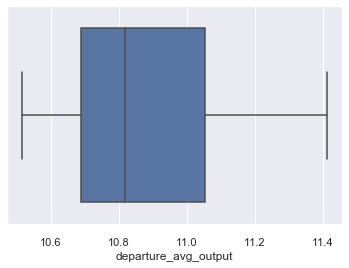

In [37]:
# This boxplot indicates that some high values for departure skew our boxplot to the right
import seaborn as sns
sns.boxplot(x=departure_airport['departure_avg_output'])

# Printing the exact value of the median for our reference
print(departure_airport["departure_avg_output"].median())

In [38]:
# Extracting the quantiles of order 0.25 and 0.75 to see where extreme values lie
departure_lower_bound = np.quantile(departure_airport['departure_avg_output'],q = 0.25)
departure_higher_bound = np.quantile(departure_airport['departure_avg_output'],q = 0.75)

# Printing the higher bound since we know the data is skewed to the right
departure_higher_bound

11.055221284769882

In [47]:
# Getting a look at our average arrival data grouped by airport
arrival_airport = X_logPAX.groupby(["Arrival","month"]).mean()
arrival_airport.reset_index(level=0, inplace=True)
arrival_airport.reset_index(level=0, inplace=True)
arrival_airport.columns = ["month",
                           "AirPort",
                           "arrival_avg_WeeksToDeparture",
                           "arrival_avg_stdwtd",
                           "arrival_avg_logPAX"]
arrival_airport.head()

,month,AirPort,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_logPAX
0,1,ATL,10.564329,8.427333,10.871551
1,2,ATL,10.036698,8.284229,10.851595
2,3,ATL,10.022357,8.164132,10.790909
3,4,ATL,10.137425,8.422937,10.953339
4,5,ATL,10.405141,8.583741,11.076267


10.816246382738031


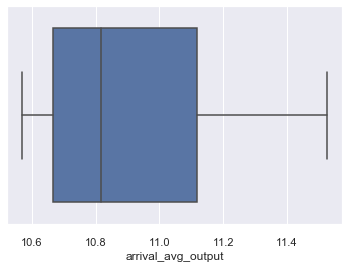

In [40]:
# This boxplot indicates two outlier States: California and New York, which we will weight heavier than the rest 
sns.boxplot(x=arrival_airport['arrival_avg_output'])
print(arrival_airport["arrival_avg_output"].median())

In [41]:
# Extracting the quantiles of order 0.25 and 0.75 to see where extreme values lie
arrival_lower_bound = np.quantile(arrival_airport['arrival_avg_output'],q = 0.25)
arrival_higher_bound = np.quantile(arrival_airport['arrival_avg_output'],q = 0.75)

# Printing the higher bound since we know the data is skewed to the right
arrival_higher_bound

11.118183583397897

In [42]:
# Getting a profile report on X test to drive our heuristics
X_output.profile_report()

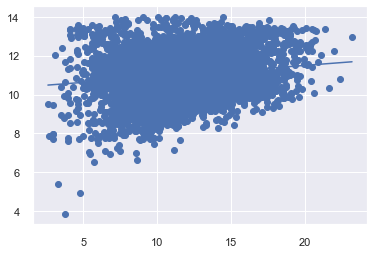

In [43]:
# Testing whether the number of weeks people book before departure explains the traffic well 
# We observe that there is a positive correlation between both albeit not very high
x = X_output["WeeksToDeparture"]
y = X_output["output"]

plt.scatter(x,y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

#### Visual representation of the data

In [44]:
import plotly.graph_objects as go
import pandas as pd


df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_flight_paths.head()

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(df_flight_paths)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths['start_lon'][i], df_flight_paths['end_lon'][i]],
            lat = [df_flight_paths['start_lat'][i], df_flight_paths['end_lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
        )
    )

fig.update_layout(
    title_text = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

NameError: name 'df_airports' is not defined

### Feature extractors

In [ ]:
# Feature extractor to date
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import math 
import numpy as np

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        
        ## External data processing
        #external_data = pd.read_csv(os.path.join(path,'external_data.csv'))
        external_data = pd.read_csv("external_data.csv")
        external_data.loc[:,"Date"] = pd.to_datetime(external_data.loc[:,"Date"])
        
        # Building column names for conditions at departure and arrival 
        col_dep = ['d_' + name for name in list(external_data.columns)]
        col_arr = [w.replace('d_', 'a_') for w in col_dep]
        
        # Fitting the names of the first 2 columns to match our original dataframe 
        col_dep = [w.replace('d_AirPort', 'Departure') for w in col_dep]
        col_dep = [w.replace('d_Date', 'DateOfDeparture') for w in col_dep]
        col_arr = [w.replace('a_AirPort', 'Arrival') for w in col_arr]
        col_arr = [w.replace('a_Date', 'DateOfDeparture') for w in col_arr]
        
        # Building 2 dataframes from data_add to get the information for the departure and arrival airports of each flight
        # Departure airport 
        external_dataDeparture = external_data.copy()
        external_dataDeparture.columns = col_dep
        # Arrival airport
        external_dataArrival = external_data.copy()
        external_dataArrival.columns = col_arr
        
        # Merging them with X_encoded 
        X_encoded = X_df.copy()
        X_encoded.loc[:,'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:,'DateOfDeparture'])
        X_encoded = pd.merge(X_encoded, external_dataDeparture, how='left',left_on=['DateOfDeparture', 'Departure'],
                             right_on=['DateOfDeparture', 'Departure'],sort=False)
        X_encoded = pd.merge(X_encoded, external_dataArrival, how='left',left_on=['DateOfDeparture', 'Arrival'],
                             right_on=['DateOfDeparture', 'Arrival'],sort=False) 
        
        ### Feature engineering
        ## Creating columns to distinguish between the two main airports for flights and the rest
        X_encoded['d_ManyFlights'] = 0  
        X_encoded['a_ManyFlights'] = 0
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ORD', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ORD', "a_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ATL', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ATL', "a_ManyFlights"] = 1
        
        ## Creating the distance variable
        # Creating latitude and longitude difference for the purpose of computing distance. 
        radius = 6371
        X_encoded["latitude_difference"] = (X_encoded["d_latitude_deg"] - X_encoded["a_latitude_deg"])
        X_encoded["longitude_difference"] = (X_encoded["d_longitude_deg"] - X_encoded["a_longitude_deg"])
        # Creating my distance column
        n,p = X_encoded.shape
        X_encoded["Distance"] = 0
        # Getting the indexes I will need 
        j = X_encoded.columns.get_loc("d_latitude_deg")
        l = X_encoded.columns.get_loc("a_latitude_deg")
        o = X_encoded.columns.get_loc("d_longitude_deg")
        t = X_encoded.columns.get_loc("a_longitude_deg")
        u = X_encoded.columns.get_loc("latitude_difference")
        v = X_encoded.columns.get_loc("longitude_difference")

        for i in np.arange(n):
            lat1 = X_encoded.iloc[i,j]
            lat2 = X_encoded.iloc[i,l]
            lon1 = X_encoded.iloc[i,o]
            lon2 = X_encoded.iloc[i,t]
            dlat = math.radians(X_encoded.iloc[i,u])
            dlon = math.radians(X_encoded.iloc[i,v])
            a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            d = radius * c
            X_encoded.iloc[i,-1] = d
        # Now dropping latitude and longitude difference
        X_encoded = X_encoded.drop(columns={"latitude_difference", "longitude_difference"})

        
        ## Categorical encoding of departure and arrival airports
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Arrival'], prefix='a'))
                                   
        ## Categorical encoding of the dates 
        X_encoded['year'] = X_encoded.loc[:,'DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded.loc[:,'DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded.loc[:,'DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded.loc[:,'DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded.loc[:,'DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded.loc[:,'DateOfDeparture'].apply(lambda date: 
                                                                         (date - pd.to_datetime("1970-01-01")).days)
        
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

    
        # Finally getting rid of departure, arrival, and date columns now that we do not need them to merge
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('DateOfDeparture',axis = 1)
        
    
        return X_encoded

In [14]:
# Light gradient boosting regressor
from sklearn.ensemble import LGBMRegressor
from sklearn.base import BaseEstimator

n_estimators = 5800
num_leaves = 31
max_depth = 5
learning_rate = 0.05
reg_alpha = 0.9
random_state = 0
class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = LGBMRegressor(
            learning_rate = learning_rate, 
            n_estimators = n_estimators, 
            num_leaves = num_leaves, 
            max_depth = max_depth, 
            reg_alpha = reg_alpha, 
            random_state = random_state)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

### Mapping heuristic columns

#### Singling out airports from States with most traffic

In [26]:
# Printing a classification of arrival States according to traffic intensity 
n,p = departure_airport.shape
for i in np.arange(n):
    cond = departure_airport["departure_avg_output"][i]
    if cond>departure_higher_bound:
        print(departure_airport.index[i],":",1)
    else:
        if cond<departure_higher_bound:
            print(departure_airport.index[i],":",-1)
        else:
            print(departure_airport.index[i],":",0) 

0 : -1
1 : -1
2 : -1
3 : -1
4 : -1
5 : -1
6 : -1
7 : -1
8 : 1
9 : -1
10 : 1
11 : 1
12 : -1
13 : -1
14 : -1
15 : 1
16 : -1
17 : -1
18 : -1
19 : 1


In [27]:
# Printing a classification of arrival States according to traffic intensity
n,p = arrival_airport.shape
for i in np.arange(n):
    cond = arrival_airport["arrival_avg_output"][i]
    if cond>arrival_higher_bound:
        print(arrival_airport.index[i],1)
    else:
        if cond<arrival_higher_bound:
            print(arrival_airport.index[i],-1)
        else:
            print(arrival_airport.index[i],0)

0 -1
1 -1
2 -1
3 -1
4 -1
5 -1
6 -1
7 -1
8 1
9 -1
10 1
11 1
12 -1
13 -1
14 -1
15 1
16 -1
17 -1
18 -1
19 1


#### The section of code that will be used in the feature encoder

In [28]:
# What I am going to add to the feature encoder
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}
X_encoded["d_State"] = X_encoded["Departure"].map(airports_to_states)
X_encoded["a_State"] = X_encoded["Arrival"].map(airports_to_states)

# Initialising weights based on state by looking at the quantiles by departure and arrival State in X_df with output
d_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "1",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "1",
"Illinois" : "1",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "1",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "-0.5",
"Washington" : "-0.5"}

a_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "2",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "-0.5",
"Illinois" : "2",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "2",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "1",
"Washington" : "-0.5"}

# Correcting state approximations with busiest airports, by looking at my extreme errors
d_busy_airport = {
    'ATL':"0",
    'ORD':"0",
    'LAX':"0",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"1",
    'EWR':"1",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0.5",
    'BOS':"1",
    'LGA': "0"}


a_busy_airport = { 
    'ATL':"1",
    'ORD':"0.5",
    'LAX':"1",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"0.5",
    'EWR':"0",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0",
    'BOS':"1",
    'LGA': "0"}

# Auxiliary columns from dictionaries to help my heuristics
X_encoded["heuristics_airports"] = 0
X_encoded["departure_importance"] = X_encoded["d_State"].map(d_TrafficIntensity)
X_encoded["arrival_importance"] = X_encoded["a_State"].map(a_TrafficIntensity)
X_encoded["arrival_airportImportance"] = X_encoded["Arrival"].map(a_busy_airport)
X_encoded["departure_airportImportance"] = X_encoded["Departure"].map(d_busy_airport)

# It seems that when both are big airports, the traffic is less important so I am taking this into account
check = X_encoded["arrival_airportImportance"].astype(float) + X_encoded["departure_airportImportance"].astype(float)
X_encoded["departure_arrival_big"] =  (check>1.25)*0.25

# Heuristics column
X_encoded["heuristics_airports"] = X_encoded["departure_importance"].astype(float)+ X_encoded["arrival_importance"].astype(float) + X_encoded["arrival_airportImportance"].astype(float) + X_encoded["departure_airportImportance"].astype(float)-X_encoded["departure_arrival_big"]

# Dropping the auxiliary columns
X_encoded = X_encoded.drop(columns = {"departure_importance", "arrival_importance","departure_airportImportance",
                       "arrival_airportImportance", "departure_arrival_big" })

NameError: name 'X_encoded' is not defined

### New try at heuristics using directly the means of groupby airport on X_df

In [22]:
external_data = pd.read_csv("submissions/starting_kit/external_data.csv")
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,DistanceToClosestHoliday,Fog_importance,Tornado_Magnitude,departure_avgWeeksToDeparture,departure_avgstd_wtd,departure_avglogPAX,arrival_avgWeeksToDeparture,arrival_avgstd_wtd,arrival_avglogPAX
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,4,0,0,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,3,0,0,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,2,0,0,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,1,0,0,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057


In [25]:
external_data = external_data.drop(columns={'arrival_avgWeeksToDeparture',
                                            'arrival_avgstd_wtd', 
                                            'arrival_avglogPAX',
                                            'departure_avgWeeksToDeparture', 
                                            'departure_avgstd_wtd',
                                            'departure_avglogPAX'})
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,DistanceToClosestHoliday,Fog_importance,Tornado_Magnitude
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,4,0,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,3,0,0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,2,0,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,1,0,0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,0,0,0


In [35]:
external_data["Date"] = pd.to_datetime(external_data["Date"])
external_data["month"] = external_data["Date"].dt.month
external_data = pd.merge(external_data, 
                         departure_airports_month, 
                         how='left', 
                         left_on=['AirPort',"month"], 
                         right_on=['Departure',"month"], 
                         sort=False)

external_data = pd.merge(external_data, 
                         arrival_airports_month, 
                         how='left', 
                         left_on=['AirPort',"month"], 
                         right_on=['Arrival',"month"], 
                         sort=False)

external_data = external_data.drop(columns={"month","Departure","Arrival"})

In [36]:
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,DistanceToClosestHoliday,Fog_importance,Tornado_Magnitude,monthly_departure_avgWeeksToDeparture,monthly_departure_avgstd_wtd,monthly_departure_avglogPAX,monthly_arrival_avgWeeksToDeparture,monthly_arrival_avgstd_wtd,monthly_arrival_avglogPAX
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,4,0,0,10.589158,8.120339,11.012571,10.760616,8.283741,10.933897
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,3,0,0,10.589158,8.120339,11.012571,10.760616,8.283741,10.933897
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,2,0,0,10.589158,8.120339,11.012571,10.760616,8.283741,10.933897
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,1,0,0,10.589158,8.120339,11.012571,10.760616,8.283741,10.933897
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,10.589158,8.120339,11.012571,10.760616,8.283741,10.933897


In [37]:
# Printing the new external file data
external_data_new = external_data.to_csv('external_dataTrainTestAirportMonth.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


#### Other version by airport only, train+test 

In [20]:
external_data = pd.merge(external_data, 
                         departure_airports, 
                         how='left', 
                         left_on=['AirPort'], 
                         right_on=['Departure'], 
                         sort=False)

external_data = pd.merge(external_data, 
                         arrival_airports, 
                         how='left', 
                         left_on=['AirPort'], 
                         right_on=['Arrival'], 
                         sort=False)
external_data.head()

NameError: name 'external_data' is not defined

In [20]:
external_data = external_data.drop(columns={'Arrival'})
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,DistanceToClosestHoliday,Fog_importance,Tornado_Magnitude,Departure,departure_avgWeeksToDeparture,departure_avgstd_wtd,departure_avglogPAX,arrival_avgWeeksToDeparture,arrival_avgstd_wtd,arrival_avglogPAX
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,4,0,0,ATL,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,3,0,0,ATL,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,2,0,0,ATL,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,1,0,0,ATL,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,ATL,10.68382,8.346205,10.990285,10.595976,8.34122,10.91057


In [21]:
# Printing the new external file data
external_data_new = external_data.to_csv('external_dataTrainTestAirport.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


### Interaction column for week-end, holidays and long week-end

In [101]:
external_data["WeekEndApproxHoliday_interaction"] = external_data.loc[:,"State_holidays"]*external_data.loc[:,"Weekend_approx"]
external_data["WeekEndApproxHoliday_interaction"].sum()

110

In [102]:
external_data["WeekEndHoliday_interaction"] = external_data.loc[:,"State_holidays"]*external_data.loc[:,"Weekend"]
external_data["WeekEndHoliday_interaction"].sum()

77

### Distances between airports

In [ ]:
X_test["d_State"] = X_test["Departure"].map(airports_to_states)

In [77]:
# Creating latitude and longitude difference for the purpose of computing distance. We will drop them later on 
radius = 6371
X_encoded["latitude_difference"] = (X_encoded["d_latitude_deg"] - X_encoded["a_latitude_deg"])
X_encoded["longitude_difference"] = (X_encoded["d_longitude_deg"] - X_encoded["a_longitude_deg"])

# Creating my distance column
n,p = X_encoded.shape
X_encoded["Distance"] = 0

# Getting the indexes I will need 
j = X_encoded.columns.get_loc("d_latitude_deg")
l = X_encoded.columns.get_loc("a_latitude_deg")
o = X_encoded.columns.get_loc("d_longitude_deg")
t = X_encoded.columns.get_loc("a_longitude_deg")
u = X_encoded.columns.get_loc("latitude_difference")
v = X_encoded.columns.get_loc("longitude_difference")

for i in np.arange(n):
    lat1 = X_encoded.iloc[i,j]
    lat2 = X_encoded.iloc[i,l]
    lon1 = X_encoded.iloc[i,o]
    lon2 = X_encoded.iloc[i,t]
    dlat = math.radians(X_encoded.iloc[i,u])
    dlon = math.radians(X_encoded.iloc[i,v])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    X_encoded.iloc[i,-1] = d

# Now dropping latitude and longitude difference
X_encoded = X_encoded.drop(columns={"latitude_difference", "longitude_difference"})

### Long week-ends

In [45]:
external_data = pd.read_csv("submissions/sarvic_2011_0935/external_data.csv")
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,interestFlightPrices
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0


In [46]:
# Getting the datetime formats for external data
external_data.loc[:,'Date'] = pd.to_datetime(external_data.loc[:,'Date'])    
j = external_data.columns.get_loc("Date")

# Initialising my prolonged week-end column
external_data["LongWeekEnd"] = 0
k = external_data.columns.get_loc("LongWeekEnd")

# Singling out the Friday
n,p = external_data.shape
for i in np.arange(n): 
    date = external_data.iloc[i,j]
    weekno = date.weekday()
    if weekno==4:
        external_data.iloc[i,k] = 1
    else:
        external_data.iloc[i,k] = 0  
print("First step completed")

# Singling out the Sunday now
n,p = external_data.shape
for i in np.arange(n): 
    date = external_data.iloc[i,j]
    weekno = date.weekday()
    if weekno==6:
        external_data.iloc[i,k] = 1
    else:
        external_data.iloc[i,k] = external_data.iloc[i,k]
external_data.head()

First step completed


,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,interestFlightPrices,LongWeekEnd
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0


### States & regions

In [50]:
# Extracting the States by airport to make a dictionary of them
# Creating an auxiliary dataframe
geog = external_data.loc[:,'latitude_deg':'longitude_deg']
geog["AirPort"] = external_data['AirPort']
geog["Date"] = external_data["Date"]


geolocator = Nominatim(timeout=3,user_agent="test_sarah") # increased the timeout threshold to avoid the error

X = geog['AirPort'].unique()
latitudes = geog['latitude_deg'].unique()
longitudes = geog['longitude_deg'].unique()

p = X.shape
a = 0
for i in np.arange(p[0]):
    location = geolocator.reverse((latitudes[i].astype(str),longitudes[i].astype(str)))
    location = location[0].split(sep =",")
    print(X[i],location[-3])

ATL  Georgia
ORD  Illinois
LAX  California
DFW  Texas
DEN  Denver County
JFK  New York
SFO  California
CLT  North Carolina
LAS  Nevada
PHX  Arizona
IAH  Texas
MIA  Florida
MCO  Florida
EWR  New Jersey
SEA  Washington
MSP  Minnesota
DTW  Michigan
PHL  Pennsylvania
BOS  Massachusetts
LGA  New York


In [51]:
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}

In [52]:
dictionary = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'}
# I have to invert this dictionary which I got from the internet
states_to_abbreviations = {y:x for x,y in dictionary.items()}

In [53]:
# Will be useful to affect regions to the airports
abbreviations_to_regions = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

In [54]:
external_data["States"] = external_data["AirPort"].map(airports_to_states)
external_data["States"] = external_data["States"].map(states_to_abbreviations)

In [55]:
external_data['Region'] = external_data['States'].map(abbreviations_to_regions)

In [56]:
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,interestFlightPrices,LongWeekEnd,States,Region
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1,GA,S
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1,GA,S
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S


### Holiday

In [682]:
# Getting the holidays for each State, by name

geolocator = Nominatim(timeout=3,user_agent="test_sarah")
external_data["Holiday"] = 0

n,p = external_data.shape
for i in np.arange(n):
    state = external_data.iloc[i,external_data.columns.get_loc("States")] # getting the State name
    us_holidays = holidays.CountryHoliday('US', prov=None, state=state) # getting the holidays for given State
    date = external_data.iloc[i,external_data.columns.get_loc("Date")] # getting the date to test
    #a = date in us_holidays # returns a boolean if this is true 
    a = us_holidays.get(date)
    #external_data.iloc[i,external_data.columns.get_loc("Holiday")] = a*1 # setting the boolean to 0 ou 1
    external_data.iloc[i,external_data.columns.get_loc("Holiday")] = a # setting the name of the holiday

# Singling out the most important holidays by manual selection
special_events = ['Christmas Day',
'Christmas Day (Observed)',
'Christmas Eve',
'Christmas Eve (Observed)',
'Day After Christmas',
'Day After Christmas, Christmas Day (Observed)',
'Day After Thanksgiving'
'Friday After Thanksgiving',
'Independence Day'
"New Year's Day", "New Year's Day (Observed)",'Thanksgiving']

external_data["Holiday"][external_data["Holiday"].isna()] = "NoHoliday"
# Giving them a bigger importance than other holidays with a for loop
n,p = external_data.shape
for i in np.arange(n):
    if external_data.iloc[i,32]=="NoHoliday":
        external_data.iloc[i,32] = 0
    else:
        if external_data.iloc[i,32] in special_events:
            external_data.iloc[i,32] = 2
        else: 
            external_data.iloc[i,32] = 1  

In [684]:
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,interestFlightPrices,LongWeekEnd,States,Region,Holiday
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1,GA,S,0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1,GA,S,0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,1


####  Holiday ID

In [70]:
# Getting only the dates with holidays in a given State
mask = (external_data["State_holidays"]!=0)
only_holidays = external_data[mask]
 
# Extracting only the columns we will need from our dataframe
holidays = only_holidays.loc[:,"Date":"AirPort"]
holidays["Holiday"] = 1
holidays.head()

In [72]:
# First setting the dates to datetime format to be able to sum the dates

holidays["Date"] = pd.to_datetime(holidays["Date"])
holidays["Holiday_id"] = 0

# Now initialising a loop to number each holiday with different numbers
n,p = holidays.shape
counter = 1
for i in np.arange(n-1):
    d1 = holidays.iloc[i,0]
    d2 = holidays.iloc[i+1,0]
    difference = (d2 - d1).days
    
    if abs(difference)>3: # if the distance between two subsequent holiday dates is bigger than 3 days
        counter = counter + 1
        holidays.iloc[i+1,3] = counter # then change holiday number
    else:
        holidays.iloc[i+1,3] = counter # else keep the same number as before
holidays.iloc[-1,3] = 383 # affecting the last value in our dataset manually
holidays.iloc[0,3] = 1 # affecting the first value in our dataset manually

In [74]:
# Now setting Holiday to Holiday_id to do a fill forward
external_data["Holiday_id"] = 0
mask = (external_data["State_holidays"]!=0)
external_data["Holiday_id"][mask] = holidays["Holiday_id"]

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_output,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_output,DistanceToClosestHoliday,Holiday_id
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.00,3,129,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.00,2,185,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.00,4,147,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.10,6,139,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,6,1,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.00,8,149,1,1,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,0,0,0,1,1,1,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,1
5,2011-09-06,ATL,24,15,90,1011,16,12,4,47,18,1.52,8,212,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,1,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
6,2011-09-07,ATL,21,14,93,1016,16,13,2,23,13,0.10,8,297,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,2,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
7,2011-09-08,ATL,23,13,87,1015,16,16,16,27,15,0.00,5,322,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
8,2011-09-09,ATL,27,12,93,1015,16,16,16,26,11,0.00,1,302,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0
9,2011-09-10,ATL,29,11,84,1019,16,16,16,21,9,0.00,0,321,1,0,0,0,0,0,33.636700,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.00000,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.327480,10.998076,0,0


In [65]:
external_data.columns = ['Date', 'AirPort', 'Max TemperatureC', 'MeanDew PointC', 'Max Humidity',
       'Max Sea Level PressurehPa', 'Max VisibilityKm', 'Mean VisibilityKm',
       'Min VisibilitykM', 'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h',
       'Precipitationmm', 'CloudCover', 'WindDirDegrees', 'Rain',
       'Thunderstorm', 'Fog', 'Snow', 'Hail', 'Tornado', 'latitude_deg',
       'longitude_deg', 'elevation_ft', '2018', '2017', '2016', '2015',
       '2017GDPPerCapita', 'Weekday', 'Weekend', 'Weekend_approx',
       'Busiest_top5', 'National_holidays', 'State_holidays', 'OtherAirports',
       'M', 'N', 'S', 'W', 'arrival_avg_WeeksToDeparture', 'arrival_avg_stdwtd',
       'arrival_avg_output', 'departure_avg_WeeksToDeparture', 'departure_avg_stdwtd',
       'departure_avg_output', 'DistanceToClosestHoliday', 'Holiday_ID', 'Holiday_id']
external_data = external_data.drop(columns={"Holiday_ID"})

#### Getting the distance to holidays for each date and airport

In [75]:
# Creating a column to fill in 
external_data["DistanceToClosestHoliday"] = 0

# Creating a dataframe with the data I need
holidayDistance = external_data.loc[:,"Date":"AirPort"]
holidayDistance["Holiday_id"] = external_data["Holiday_id"]
holidayDistance["DistanceToClosestHoliday"] = external_data["DistanceToClosestHoliday"]
holidayDistance["Date"] = pd.to_datetime(holidayDistance["Date"])
holidayDistance.head()

,Date,AirPort,Holiday_id,DistanceToClosestHoliday
0,2011-09-01,ATL,0,0
1,2011-09-02,ATL,0,0
2,2011-09-03,ATL,0,0
3,2011-09-04,ATL,0,0
4,2011-09-05,ATL,1,0


In [120]:
# Distance to incoming holiday
n,p = holidayDistance.shape
holidayDistance["DistanceToIncomingHoliday"] = 0
for i in np.arange(n):
    # Fix the right date to refer to
    checkholiday = holidayDistance.iloc[i,2]
    counter = i 
    while (counter<(n-1)) and (checkholiday == 0):
        counter = counter + 1
        checkholiday = holidayDistance.iloc[counter,2]
    next_holiday = holidayDistance.iloc[counter,0]
    
    # Then compute the distance
    current_date = holidayDistance.iloc[i,0]
    holidayDistance.iloc[i,4] = abs(next_holiday - current_date).days

In [121]:
# Distance to last holiday
holidayDistance["DistanceToLastHoliday"] = 0
for i in np.arange(n):
    # Fix the right date to refer to
    checkholiday = holidayDistance.iloc[i,2]
    counter = i 
    while (counter>0) and (checkholiday == 0):
        counter = counter - 1
        checkholiday = holidayDistance.iloc[counter,2]
    last_holiday = holidayDistance.iloc[counter,0]
    
    # Then compute the distance
    current_date = holidayDistance.iloc[i,0]
    holidayDistance.iloc[i,5] = abs(last_holiday - current_date).days

In [128]:
holidayDistance["DistanceToClosestHoliday"] = pd.DataFrame(
    [holidayDistance["DistanceToIncomingHoliday"],holidayDistance["DistanceToLastHoliday"]]
    ).min()

# Correcting the first 4 rows
holidayDistance["DistanceToClosestHoliday"].iloc[0:4] = holidayDistance["DistanceToIncomingHoliday"].iloc[0:4]

,Date,AirPort,Holiday_id,DistanceToClosestHoliday,DistanceToIncomingHoliday,DistanceToLastHoliday
0,2011-09-01,ATL,0,0,4,0
1,2011-09-02,ATL,0,0,3,1
2,2011-09-03,ATL,0,0,2,2
3,2011-09-04,ATL,0,0,1,3
4,2011-09-05,ATL,1,0,0,0
5,2011-09-06,ATL,0,0,34,1
6,2011-09-07,ATL,0,0,33,2
7,2011-09-08,ATL,0,0,32,3
8,2011-09-09,ATL,0,0,31,4
9,2011-09-10,ATL,0,0,30,5


In [144]:
holidayDistance = holidayDistance.drop(columns={"DistanceToIncomingHoliday","DistanceToLastHoliday","Holiday_id"})
holidayDistance.head()

,Date,AirPort,DistanceToClosestHoliday
0,2011-09-01,ATL,4
1,2011-09-02,ATL,3
2,2011-09-03,ATL,2
3,2011-09-04,ATL,1
4,2011-09-05,ATL,0


In [147]:
external_data["Date"] = pd.to_datetime(external_data["Date"])
external_data = pd.merge(external_data, holidayDistance, 
                         how='left',
                         left_on=['Date', 'AirPort'],
                         right_on=['Date', 'AirPort'],
                         sort=False)
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_output,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_output,DistanceToClosestHoliday
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,4
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,3
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,2
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,1
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,0


### Encoding categorical data

In [57]:
external_data = external_data.join(pd.get_dummies(external_data.loc[:,'Region']))
external_data = external_data.drop(columns={"Region"})

### Feature engineering: counting the number of airports in a state

In [58]:
external_data = external_data.join(pd.get_dummies(external_data.loc[:,'States']))

state_columns =  ['AZ', 'CA', 'CO', 'FL', 'GA', 'IL', 'MA', 'MI',
       'MN', 'NC', 'NJ', 'NV', 'NY', 'PA', 'TX', 'WA']

airports = ['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'JFK', 'SFO', 'CLT', 'LAS',
       'PHX', 'IAH', 'MIA', 'MCO', 'EWR', 'SEA', 'MSP', 'DTW', 'PHL',
       'BOS', 'LGA']


In [64]:
mylist = []
counter = 0
for state in state_columns: 
    state_localisation = external_data.columns.get_loc(state)
    counter = 0
    for airport in airports: 
        mask = (external_data["AirPort"] == airport)
        check_data = external_data[mask]
        summary = check_data.sum(axis=0)
        summary = summary[state_localisation]
        if summary > 0:
            counter = counter + 1
        else:
            counter = counter
    print(state,counter)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [42]:
state_to_number_other_airports = {"AZ": "0",
           "CA": "1",
           "CO" : "0",
           "FL" : "1",
           "GA" : "0",
           "IL" : "0",
           "MA" : "0",
           "MI" : "0",
           "MN" : "0",
           "NC" : "0",
           "NJ" : "0",
           "NV" : "0",
           "NY" : "1",
           "PA" : "0",
           "TX" : "1",
           "WA" : "0"}

In [41]:
# Reloading my dataframe with the State column to map my airports
external_data2 = pd.read_csv("external_dataTEST.csv")
external_data2.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,interestFlightPrices,LongWeekEnd,States,Region,Holiday
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,1,GA,S,0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,80.0,0,GA,S,2


In [43]:
external_data["OtherAirports"] = external_data2["States"].map(state_to_number_other_airports)
external_data.head()

In [ ]:
# Don't forget to rerun categorical encoding before saving the file as external data

### Getting airport performance by month in terms of being on time

In [292]:
airport_performance = pd.read_csv("data/ontime_byairport.csv")

airport_performance.columns = ['Dates', 'ATL', 'BOS', 'BWI', 'CLT', 'DCA', 'DEN', 'DFW', 'DTW',
       'EWR', 'FLL', 'HNL', 'IAD', 'IAH', 'JFK', 'LAS', 'LAX', 'LGA', 'MCO',
       'MDW', 'MIA', 'MSP', 'ORD', 'PDX', 'PHL', 'PHX', 'SAN', 'SEA', 'SFO',
       'SLC', 'TPA',]

airport_performance2 = airport_performance.drop([0,13,26]).reset_index()



In [293]:
# Unraveling the data in my pivot table into a single column
performance_column = np.ravel(airport_performance2.loc[:,"ATL":"TPA"])
performance_column = pd.DataFrame(performance_column)

# Encoding the row of airports I will need 
airport_col = pd.DataFrame()
for airport_name in airport_performance.columns:
    airport_table = pd.DataFrame([airport_name])
    airport_table = airport_table.append([airport_table]*11)
    airport_col = airport_col.append(airport_table)
airport_col = airport_col.reset_index()
print(airport_col.shape)

airport_performance2 = airport_col.drop(airport_col.index[0:12]).reset_index()
airport_performance2.columns = ["month","year","AirPort"]
airport_performance2 = airport_performance2.append([airport_performance2]*2)

# Months
n,p = airport_performance2.shape
month = 0
for i in np.arange(n):
    month = month + 1
    airport_performance2.iloc[i,0] = month
    if (month%12 == 0):
        month = 0

# Years
year = 2011
counter = 0
for i in np.arange(n):
    counter = counter+1
    year = year
    airport_performance2.iloc[i,1] = year
    if (counter%360==0):
        year = year + 1

(372, 2)


In [296]:
# Performing the join
airport_performance = airport_performance2.join(performance_column, how = "left").reset_index()
airport_performance = airport_performance.drop(columns = {"index"})
airport_performance.columns = ["month","year","AirPort","PercentageOnTime"]
airport_performance.head()

,month,year,AirPort,PercentageOnTime
0,1,2011,ATL,0.74
1,1,2012,ATL,0.74
2,1,2013,ATL,0.74
3,2,2011,ATL,0.68
4,2,2012,ATL,0.68


In [20]:
external_data["Date"] = pd.to_datetime(external_data["Date"])
external_data['year'] = external_data.loc[:,'Date'].dt.year
external_data['month'] = external_data.loc[:,'Date'].dt.month
external_data['day'] = external_data.loc[:,'Date'].dt.day
external_data['week'] = external_data.loc[:,'Date'].dt.week

external_data = pd.merge(external_data, airport_performance, how='left',
                         left_on=['year','month','AirPort'], 
                         right_on=['year','month','AirPort'],sort=False)
external_data = external_data.drop(columns = {"year", "month", "week"})
external_data.head()

In [27]:
# Printing the new external file data
external_data_new = external_data.to_csv('external_data.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


### Removing highly correlated columns

In [705]:
# Getting the columns that are not correlated and removing them
external_data_test = external_data
covarianceMatrix = external_data_test.corr()
listOfFeatures = [i for i in covarianceMatrix]
setOfDroppedFeatures = set() 
for i in range(len(listOfFeatures)) :
    for j in range(i+1,len(listOfFeatures)): #Avoid repetitions 
        feature1=listOfFeatures[i]
        feature2=listOfFeatures[j]
        if abs(covarianceMatrix[feature1][feature2]) > 0.8: #If the correlation between the features is > 0.8
            setOfDroppedFeatures.add(feature1) #Add one of them to the set
#I tried different values of threshold and 0.8 was the one that gave the best results
external_data_uncorr = external_data_test.drop(setOfDroppedFeatures, axis=1)

In [706]:
external_data_test.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,HigherTraffic_Dates,M,N,S,W,OtherAirports
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,0,NaN
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,1,0,0,1,0,NaN
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,0,NaN
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,1,0,0,1,0,NaN
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,1,0,0,1,0,NaN


In [707]:
external_data_test.shape

(11040, 34)

### Adding transportation consumption by State

In [121]:
transportation_consumption = pd.read_csv("data/airtraffic_transportationConsumption.csv")

# Creating an airports column
states_to_airports = {y:x for x,y in airports_to_states.items()}
transportation_consumption["AirPort"] = transportation_consumption["State"].map(states_to_airports)

# Cleaning from NaNs
transportation_consumption = transportation_consumption.dropna()
transportation_consumption = transportation_consumption.reset_index()

# Converting energy consumed column to floats
transportation_consumption["transportation_energy_consumedBtU"] = transportation_consumption["transportation_energy_consumedBtU"].str.replace(",","")
transportation_consumption["transportation_energy_consumedBtU"] = transportation_consumption.apply(lambda x: float(
                                                x["transportation_energy_consumedBtU"]),
                                                axis=1)
transportation_consumption = transportation_consumption.drop(columns={"index","State"})

# Getting the mean consumption to fill in NaNs after the merge with external_data
consumption_mean = transportation_consumption["transportation_energy_consumedBtU"].mean()

# Renaming the columns
transportation_consumption.columns = ["energy_consumed","AirPort"]
transportation_consumption.head()

,energy_consumed,AirPort
0,459.8,PHX
1,2907.8,SFO
2,402.2,DEN
3,1466.0,MCO
4,823.2,ATL


In [122]:
external_data = pd.merge(external_data, transportation_consumption,
                         how='left',
                         left_on=['AirPort'],
                         right_on=['AirPort'],
                         sort=False)

mask = external_data["energy_consumed"].isna()
external_data["energy_consumed"][mask] = consumption_mean

external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekendeparture_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_output,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_output,day,PercentageOnTime,energy_consumed
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,1,0.68,823.2
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,2,0.68,823.2
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,3,0.68,823.2
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,4,0.68,823.2
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,5,0.68,823.2


### Weather feature engineering

In [162]:
external_data = pd.read_csv("submissions/starting_kit/external_data.csv")
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_output,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_output,DistanceToClosestHoliday
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,4
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,3
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,2
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,1
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,0


In [164]:
weather = external_data.loc[:,"Date":"Tornado"]
weather.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0


In [197]:
external_data["Fog_importance"] = external_data["Mean VisibilityKm"]*external_data["Fog"]
external_data["Tornado_Magnitude"] = external_data["Max Wind SpeedKm/h"]*external_data["Tornado"]
external_data["Thunderstorm_Magnitude"] = external_data["Max Wind SpeedKm/h"]*external_data["Thunderstorm"]*external_data["Precipitationmm"]

In [196]:
print(weather["Precipitationmm"].mean())
mask = weather["Thunderstorm"] == 1
print(weather[mask]["Precipitationmm"].mean())

2.2175634057970517
11.660628078817783


In [198]:
external_data.head()

,Date,AirPort,Max TemperatureC,MeanDew PointC,Max Humidity,Max Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,WindDirDegrees,Rain,Thunderstorm,Fog,Snow,Hail,Tornado,latitude_deg,longitude_deg,elevation_ft,2018,2017,2016,2015,2017GDPPerCapita,Weekday,Weekend,Weekend_approx,Busiest_top5,National_holidays,State_holidays,OtherAirports,M,N,S,W,arrival_avg_WeeksToDeparture,arrival_avg_stdwtd,arrival_avg_output,departure_avg_WeeksToDeparture,departure_avg_stdwtd,departure_avg_output,DistanceToClosestHoliday,Fog_importance,Tornado_Magnitude,Thunderstorm_Magnitude
0,2011-09-01,ATL,35,18,79,1022,16,16,11,19,6,0.0,3,129,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,3,0,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,4,0,0,0.0
1,2011-09-02,ATL,36,15,61,1019,16,16,16,24,7,0.0,2,185,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,4,0,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,3,0,0,0.0
2,2011-09-03,ATL,35,16,64,1015,16,16,16,19,7,0.0,4,147,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,5,1,0,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,2,0,0,0.0
3,2011-09-04,ATL,27,19,93,1014,16,14,4,21,9,6.1,6,139,1,0,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,6,1,1,1,0,0,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,1,0,0,0.0
4,2011-09-05,ATL,26,22,94,1010,16,13,3,32,16,16.0,8,149,1,1,0,0,0,0,33.6367,-84.428101,1026.0,51866464,50251964,50501858,49340732,56840.0,0,0,0,1,1,1,0,0,0,1,0,10.621225,8.365852,10.930859,10.675858,8.32748,10.998076,0,0,0,512.0


### Fine tuning the parameters

In [3]:
# Selected feature extractor
import pandas as pd
import os
import math 
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import RobustScaler


def compute_distance(X_encoded):
    return X_encoded.apply(
        lambda x: geodesic(
            (x["d_latitude_deg"],x["d_longitude_deg"]),
            (x["a_latitude_deg"],x["a_longitude_deg"])
        ).km,
        axis=1,
    )
                          
class FeatureExtractor(object):
    def __init__(self):
        pass


    def fit(self, X_df, y_array):
        pass


    def transform(self, X_df):
        X_encoded = X_df.copy()
        path = os.path.dirname(__file__)
        

        external_data = pd.read_csv(os.path.join(path,'external_data.csv'))
        external_data.loc[:,"Date"] = pd.to_datetime(external_data.loc[:,"Date"])
        
        # Building column names for conditions at departure and arrival 
        col_dep = ['d_' + name for name in list(external_data.columns)]
        col_arr = [w.replace('d_', 'a_') for w in col_dep]
        # Fitting the names of the first 2 columns to match our original dataframe 
        col_dep = [w.replace('d_AirPort', 'Departure') for w in col_dep]
        col_dep = [w.replace('d_Date', 'DateOfDeparture') for w in col_dep]
        col_arr = [w.replace('a_AirPort', 'Arrival') for w in col_arr]
        col_arr = [w.replace('a_Date', 'DateOfDeparture') for w in col_arr]
        
        # Building 2 dataframes from dexternal_data to get the information for the departure and arrival airports of each flight
        # Departure airport 
        external_dataDeparture = external_data.copy()
        external_dataDeparture.columns = col_dep
        # Arrival airport
        external_dataArrival = external_data.copy()
        external_dataArrival.columns = col_arr
        

        # Merging them with X_encoded 
        X_encoded.loc[:,'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:,'DateOfDeparture'])
        X_encoded = pd.merge(X_encoded, external_dataDeparture, how='left',left_on=['DateOfDeparture', 'Departure'],
                             right_on=['DateOfDeparture', 'Departure'],sort=False)
        X_encoded = pd.merge(X_encoded, external_dataArrival, how='left',left_on=['DateOfDeparture', 'Arrival'],
                             right_on=['DateOfDeparture', 'Arrival'],sort=False) 

        ### Feature engineering
        ## Creating columns to distinguish between the two main airports for flights and the rest
        X_encoded['d_ManyFlights'] = 0  
        X_encoded['a_ManyFlights'] = 0
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ORD', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ORD', "a_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ATL', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ATL', "a_ManyFlights"] = 1

        # Getting the interaction of departure and arrival on the output
        # We inputted the average output by departure/arrival airport in external data
        print(X_encoded.columns)
        X_encoded["logPAX_interaction"] = X_encoded.loc[:,"d_departure_avglogPAX"]*X_encoded.loc[:,"a_arrival_avglogPAX"]
        X_encoded["DistanceToHoliday_interaction"] = X_encoded.loc[:,"d_DistanceToClosestHoliday"]*X_encoded.loc[:,"a_DistanceToClosestHoliday"]
        X_encoded["GDPPerCapita_interaction"] = X_encoded.loc[:,"d_GDPPerCapita_2017"]*X_encoded.loc[:,"a_GDPPerCapita_2017"]
        X_encoded["Region_interaction"] = X_encoded.loc[:,"d_M"]*X_encoded.loc[:,"a_M"] \
        + X_encoded.loc[:,"d_S"]*X_encoded.loc[:,"a_S"] + \
        X_encoded.loc[:,"d_N"]*X_encoded.loc[:,"a_N"] +\
        X_encoded.loc[:,"d_W"]*X_encoded.loc[:,"a_W"]
        X_encoded["passenger_interaction"] = X_encoded["d_passengers_2015"]*X_encoded["a_passengers_2015"] 
        X_encoded["MaxTemperature_interaction"] = X_encoded.loc[:,"d_Max TemperatureC"]*X_encoded.loc[:,"a_Max TemperatureC"]


        # Distance
        X_encoded["Distance"] = compute_distance(X_encoded)

        
        ## Categorical encoding of departure and arrival airports
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Arrival'], prefix='a'))
                                   
        ## Categorical encoding of the dates 
        X_encoded['year'] = X_encoded.loc[:,'DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded.loc[:,'DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded.loc[:,'DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded.loc[:,'DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded.loc[:,'DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded.loc[:,'DateOfDeparture'].apply(lambda date: 
                                                                         (date - pd.to_datetime("1970-01-01")).days)
        
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    
        # Finally getting rid of departure, arrival, and date columns now that we do not need them to merge
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('DateOfDeparture',axis = 1)

    
        return X_encoded

In [4]:
# Basic combined regressor 
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingRegressor

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = GradientBoostingRegressor(n_estimators=8000, 
        									learning_rate=0.1, 
        									max_features='sqrt', 
        									min_samples_leaf=20, 
        									max_depth=10, 
        									min_samples_split=10)
      

    def fit(self, X, y):
        self.reg.fit(X,y)
     


    def predict(self, X):
        pred1 = self.reg.predict(X)
     
        return pred1

In [5]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'

# Getting our inputs
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()

# Transforming our inputs
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array_train = fe.transform(X_df)

Index(['DateOfDeparture', 'Departure', 'Arrival', 'WeeksToDeparture',
       'std_wtd', 'd_Max TemperatureC', 'd_MeanDew PointC', 'd_Max Humidity',
       'd_Max Sea Level PressurehPa', 'd_Max VisibilityKm',
       'd_Mean VisibilityKm', 'd_Min VisibilitykM', 'd_Max Wind SpeedKm/h',
       'd_Mean Wind SpeedKm/h', 'd_Precipitationmm', 'd_CloudCover',
       'd_WindDirDegrees', 'd_Rain', 'd_Thunderstorm', 'd_Fog', 'd_Snow',
       'd_Hail', 'd_Tornado', 'd_latitude_deg', 'd_longitude_deg',
       'd_elevation_ft', 'd_passengers_2018', 'd_passengers_2017',
       'd_passengers_2016', 'd_passengers_2015', 'd_GDPPerCapita_2017',
       'd_Weekend', 'd_Weekend_approx', 'd_Busiest_top5',
       'd_National_holidays', 'd_State_holidays', 'd_OtherAirports', 'd_M',
       'd_N', 'd_S', 'd_W', 'd_DistanceToClosestHoliday', 'd_Fog_importance',
       'd_Tornado_Magnitude', 'd_departure_avgWeeksToDeparture',
       'd_departure_avgstd_wtd', 'd_departure_avglogPAX',
       'd_arrival_avgWeeksToDepa

In [115]:
# Fitting our model
reg_train = Regressor()
reg_train.fit(X_array_train, y_array)

In [95]:
# Loading the test data
X_test, y_test = problem.get_test_data()

# Transforming our inputs
fe = FeatureExtractor()
fe.fit(X_test, y_test)
X_array_test = fe.transform(X_test)

# Fitting our model
reg_test = Regressor()
reg_test.fit(X_array_test, y_test)

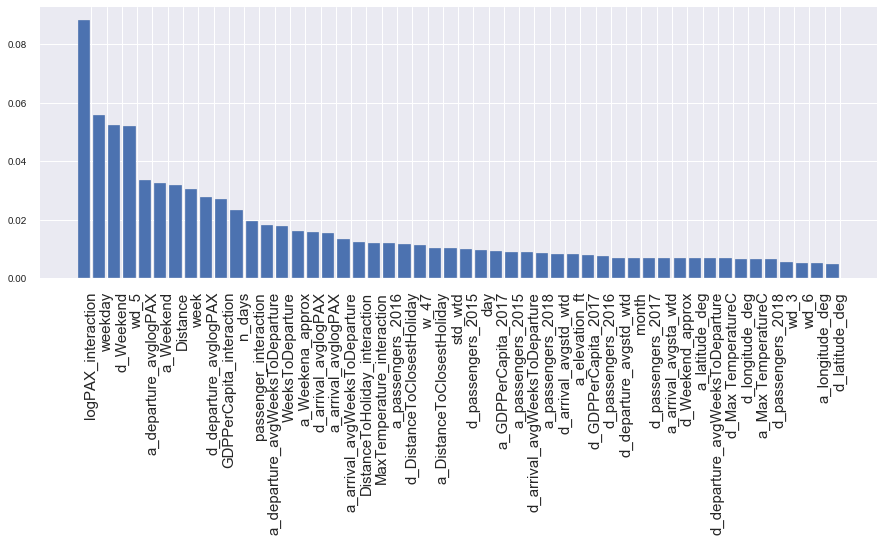

In [116]:
# Looking at the importance of each column and the prediction 
X_columns = X_array_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg_train.reg.feature_importances_)[::-1][:50]

importances = reg_train.reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [8]:
gradient_params = {
    'n_estimators':[3000,5000,8000,10000], 'min_samples_split': [5,10,20,30], 'max_depth':[10,20,30]}
model_boost = {
    'GradientBoost': GridSearchCV(GradientBoostingRegressor(
                                  alpha=0.9, 
                                  criterion='friedman_mse', 
                                  init=None,
                                  learning_rate=0.1, 
                                  loss='ls', 
                                  max_features='sqrt', 
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None,
                                  min_samples_leaf=20, 
                                  min_weight_fraction_leaf=0.0,
                                  n_iter_no_change=None, 
                                  presort='auto',
                                  random_state=0, 
                                  subsample=1.0, 
                                  tol=0.0001,
                                  validation_fraction=0.1, 
                                  verbose=0, 
                                  warm_start=False),
                    param_grid = gradient_params, 
                    scoring = "neg_mean_squared_error").fit(X_array_train, y_array).best_estimator_}

KeyboardInterrupt: 

In [ ]:
model_boost

In [225]:
gradient_params = {
    'min_samples_leaf' : [5,8,10]}

model_boost2 = {
    'GradientBoost': GridSearchCV(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', 
                                                            n_estimators = 5800, 
                                                            init=None, 
                                                            learning_rate=0.05, loss='ls', 
                                                            max_depth=4, 
                                                            max_features='sqrt', 
                                                            max_leaf_nodes=None, 
                                                            min_impurity_decrease=0.0, 
                                                            min_impurity_split=None,
                                                            min_samples_split=10, 
                                                            min_weight_fraction_leaf=0.0, 
                                                            n_iter_no_change=None, 
                                                            presort='auto', 
                                                            random_state=0, 
                                                            subsample=1.0, 
                                                            tol=0.0001, 
                                                            validation_fraction=0.1, 
                                                            verbose=0, 
                                                            warm_start=False),
                                  param_grid = gradient_params,
                                  scoring = "neg_mean_squared_error").fit(X_array, y_array).best_estimator_}

KeyboardInterrupt: 

In [ ]:
model_boost2

In [76]:
forest_params = {'n_estimators':[205,215,225]}
model_random = {'RandomForestRegressor': GridSearchCV(RandomForestRegressor(),
                                                      param_grid=forest_params).fit(X_array, y_array).best_estimator_,}

In [77]:
model_random

{'RandomForestRegressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=205,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}

In [17]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

histgradient_params = {'max_iter' : [500,1500], 
                       'min_samples_leaf' : [20,30,50]}

model_histgrad = {'HistGradientBoostingRegressor': GridSearchCV(HistGradientBoostingRegressor(), 
                 param_grid = histgradient_params).fit(X_array_train, y_array).best_estimator_}


In [18]:
model_histgrad

{'HistGradientBoostingRegressor': HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                               loss='least_squares', max_bins=256,
                               max_depth=None, max_iter=1500, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0)}

### Getting the last external data to date - Changes with time

In [101]:
external_data = pd.read_csv("submissions/starting_kit/external_data.csv")
# A bunch of useful tests to run before submitting external data
external_data.isna().sum()
#pd.to_datetime(external_data["Date"])


Date                                     0
AirPort                                  0
Max TemperatureC                         0
MeanDew PointC                           0
Max Humidity                             0
Max Sea Level PressurehPa                0
Max VisibilityKm                         0
Mean VisibilityKm                        0
Min VisibilitykM                         0
Max Wind SpeedKm/h                       0
Mean Wind SpeedKm/h                      0
Precipitationmm                          0
CloudCover                               0
WindDirDegrees                           0
Rain                                     0
Thunderstorm                             0
Fog                                      0
Snow                                     0
Hail                                     0
Tornado                                  0
latitude_deg                             0
longitude_deg                            0
elevation_ft                             0
2018       

In [102]:
external_data = external_data.drop(columns={"Weekday"})

In [103]:
# Printing the new external file data
external_data_new = external_data.to_csv('external_dataDropped.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


In [44]:
external_data.columns = ['Date', 
                         'AirPort', 
                         'Max TemperatureC', 
                         'MeanDew PointC', 
                         'Max Humidity', 
                         'Max Sea Level PressurehPa', 
                         'Max VisibilityKm', 
                         'Mean VisibilityKm',
                         'Min VisibilitykM', 
                         'Max Wind SpeedKm/h', 
                         'Mean Wind SpeedKm/h',
                         'Precipitationmm', 
                         'CloudCover', 
                         'WindDirDegrees', 
                         'Rain',
                         'Thunderstorm',
                         'Fog', 
                         'Snow', 
                         'Hail',
                         'Tornado', 
                         'latitude_deg',
                         'longitude_deg', 
                         'elevation_ft', 
                         'passengers_2018', 
                         'passengers_2017', 
                         'passengers_2016', 
                         'passengers_2015',
                         'GDPPerCapita_2017', 
                         'Weekday', 
                         'Weekend', 
                         'Weekend_approx',
                         'Busiest_top5', 
                         'National_holidays', 
                         'State_holidays', 
                         'OtherAirports',
                         'M', 
                         'N', 
                         'S', 
                         'W', 
                         'DistanceToClosestHoliday', 
                         'Fog_importance',
                         'Tornado_Magnitude', 
                         'departure_avgWeeksToDeparture',
                         'departure_avgstd_wtd', 
                         'departure_avglogPAX',
                         'arrival_avgWeeksToDeparture', 
                         'arrival_avgstd_wtd',
                         'arrival_avglogPAX']

### Getting the best external data to date and adding my new features - Changes with time

In [5]:
external_data = pd.read_csv("submissions/sarvic_2611_0954/external_data.csv")
external_data2.isna().sum()

Date                         0
AirPort                      0
Max TemperatureC             0
MeanDew PointC               0
Max Humidity                 0
Max Sea Level PressurehPa    0
Max VisibilityKm             0
Mean VisibilityKm            0
Min VisibilitykM             0
Max Wind SpeedKm/h           0
Mean Wind SpeedKm/h          0
Precipitationmm              0
CloudCover                   0
WindDirDegrees               0
Rain                         0
Thunderstorm                 0
Fog                          0
Snow                         0
Hail                         0
Tornado                      0
latitude_deg                 0
longitude_deg                0
elevation_ft                 0
2018                         0
2017                         0
2016                         0
2015                         0
2017GDPPerCapita             0
Weekday                      0
Weekend                      0
Weekend_approx               0
Busiest_top5                 0
National

In [128]:
external_data2.shape

(11040, 45)

In [62]:
# Printing the new external file data
external_data_new = external_data.to_csv('external_data.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


### Testing the file

In [11]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse       time
	train  0.060  25.860739
	valid  0.387   4.553987
	test   0.399   1.257644
CV fold 1
	score   rmse       time
	train  0.057  24.317707
	valid  0.395   4.549754
	test   0.410   1.389519
CV fold 2
	score   rmse       time
	train  0.056  24.355668
	valid  0.390   4.545997
	test   0.403   1.280413
CV fold 3
	score   rmse       time
	train  0.057  24.379748
	valid  0.399   5.840010
	test   0.423   1.581188
CV fold 4
	score   rmse       time
	train  0.061  28.490115
	valid  0.374   4.425470
	test   0.394   1.253072
CV fold 5
	score   rmse       time
	train  0.058  22.361668
	valid  0.369   4.415290
	test   0.386   1.230960
CV fold 6
	score   rmse       time
	train  0.057  22.975506
	valid  0.373   5.187612
	test   0.386   1.345446
CV fold 7
	score   rmse       time
	train  0.058  24.343209
	valid  0.380   4.923862
	te